In [1]:
import numpy as np
import random as rd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotnine import *
import helpFxs
from helpFxs import expParas
from helpFxs import sample2dist
from helpFxs import findOptim
from helpFxs import drawSample
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
myTheme = theme(panel_grid_major = element_blank(),
        panel_grid_minor = element_blank(),
                text=element_text(face = "bold", size = 15),
        axis_line = element_line(size = 1),
        panel_background = element_rect(fill = "white"),
        strip_background = element_blank(),
        # adjust X-axis labels; also adjust their position using margin (acts like a bounding box)
        # using margin was needed because of the inwards placement of ticks
        # axis_text_x = element_text(margin = unit(c(t = 2.5, r = 0, b = 0, l = 0), "mm")),
        # adjust Y-axis title
        axis_title_y = element_text(face = "bold"),
        # adjust Y-axis labels
        # axis_text_y = element_text(margin = unit(c(t = 0, r = 2.5, b = 0, l = 0), "mm")),
        # length of tick marks - negative sign places ticks inwards
        # axis_ticks_length = unit(-1.4, "mm"),
        # width of tick marks in mm
        axis_ticks = element_line(size = 1)
        ) 


In [2]:
conditions, delayMaxs, blockMin, blockSec, nBlock, tokenValue, smallReward, iti, pareto, tGrid, kmGrid = expParas()

In [3]:
########  optimal analysis #######
########  I might want to improve my code ########

# end of each time bin 
# vairables, time, CDF and PDF are of the same dimensions 

bin = 0.1 
time = {
    "HP": bin * np.arange(1, delayMaxs[0] / bin + 1), # probably linspace is a better choice 
    "LP": bin * np.arange(1, delayMaxs[1] / bin + 1)
}

# delay CDFS
### delays in HP follow unif(0, 20)
### delays in LP follow pareto(mu = 0, k =4, sigma = 2), truncated at 40
HP = 1 / len(time['HP']) * np.linspace(start=1, stop=len(time['HP']), num=len(time['HP'])) # here range is used as meaningful numbers rather than simple indexs
mu = pareto['mu']; k = pareto['k']; sigma = pareto['sigma']; # parameters for the pareto distribution
LP = 1 - (1 + k * (time['LP']- mu) / sigma) ** (-1 / k)
LP[-1] = 1 # truncated at 40
rewardDelayCDFs = {
    "HP": HP,
    "LP": LP
}

# delay PDFS
HP = np.diff(np.append(0, rewardDelayCDFs['HP']))
LP = np.diff(np.append(0, rewardDelayCDFs['LP']))
rewardDelayPDFs = {
    "HP": HP,
    "LP": LP
}

# average waiting durations given different policies
# using the trapezoid rule 
HP = np.cumsum((time['HP'] - 0.5 * bin) * rewardDelayPDFs['HP']) / np.cumsum(rewardDelayPDFs['HP'])
LP = np.cumsum((time['LP'] - 0.5 * bin) * rewardDelayPDFs['LP']) / np.cumsum(rewardDelayPDFs['LP'])
meanRewardDelays = {
    "HP": HP,
    "LP": LP
}

# rewardRates given different policies
## might be different from the values used in expParas.R, 
## which are calcuated with a higher temporal resoluation
HP = (tokenValue * rewardDelayCDFs['HP'] + smallReward * (1 - rewardDelayCDFs['HP'])) / \
((meanRewardDelays['HP'] * rewardDelayCDFs['HP'] + time['HP'] * (1 - rewardDelayCDFs['HP'])) + iti)
LP = (tokenValue * rewardDelayCDFs['LP'] + smallReward * (1 - rewardDelayCDFs['LP']))/ \
((meanRewardDelays['LP'] * rewardDelayCDFs['LP'] + time['LP'] * (1 - rewardDelayCDFs['LP'])) + iti)
rewardRates = {
    "HP": HP,
    "LP": LP
}

# optimal raward rates and optimal policies
optimWaitThresholds = {
    "HP": time['HP'][np.argmax(HP)],
    "LP": time['LP'][np.argmax(LP)]
}
optimRewardRates = {
    "HP": max(HP),
    "LP": max(LP)
}

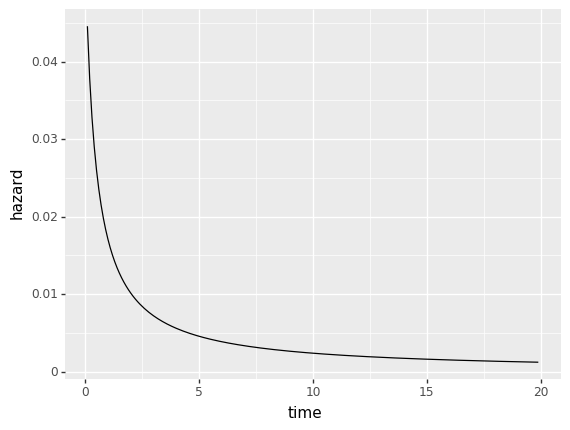

<ggplot: (8771301104425)>

In [41]:
# calcualte the hazard function 
HP = rewardDelayPDFs['HP'] / (1 - rewardDelayCDFs['HP'] + rewardDelayPDFs['HP'])
HP

plotData = pd.DataFrame({
    "time":  time['HP'],
    "hazard": HP 
}
)

# ggplot(plotData.loc[plotData['time'] < 18,], aes("time", "hazard")) + geom_line() 


LP = rewardDelayPDFs['LP'] / (1 - rewardDelayCDFs['LP'] + rewardDelayPDFs['LP'])
LP

plotData = pd.DataFrame({
    "time":  time['LP'],
    "hazard": LP 
}
)

ggplot(plotData.loc[plotData['time'] < 20,], aes("time", "hazard")) + geom_line() 

In [235]:
# add more formulas later
def wtw(time, CDF, tokenValue, smallValue, iti, delayMax, isPlot):
    '''Create a wtw object 
    
    Key arguments:
        
        time -- bin, 2 * bin, 3 * bin, ....
        CDF -- the same dimension as time
        tokenValue --
        
    Key outputs:
        PDF -- the same dimension as time. When do integration 
    
    
    '''
    
    # sanity check 
    if time.shape[0] != CDF.shape[0]:
        print("time and CDF have different dimensions")
        return 
    if CDF[-1] < 1 - 0.001:
        print('CDF is not appropiratly defined')
        
    # print the temporal resolution that the computations are based on
    print("Generating results at time steps of %2.4f second" % (time[1] - time[0]))
    
    # calculate PDF, PDF(t) = CDF(t) - CDF(t-1)
    PDF = np.diff(np.append(0, CDF))
    if isPlot:
        figPDF = ggplot(pd.DataFrame({'Time': time, 'PDF': PDF}), aes("Time", "PDF")) + geom_line()
        
    
    # average waiting durations given different policies
    # Here we assume rewards occur at the middle of each time bin 
    meanRewardDelay = np.cumsum((time - 0.5 * bin) * PDF) / np.cumsum(PDF)
  
    
    # rewardRates given different policie
    meanRewardRate = (tokenValue * CDF + smallReward * (1 - CDF)) / \
    ((meanRewardDelay * CDF + time * (1 - CDF)) + iti)
    if isPlot:
        figRewardRate = ggplot(pd.DataFrame({'Time': time, 'rewardRate': meanRewardRate}), aes("Time", "rewardRate")) + geom_line() +\
        ylab("Mean reward rate")
        
    # hazard function
    hazard = PDF / (1 - CDF + PDF) 
    if isPlot:
        figHazard = ggplot(pd.DataFrame({'Time': time, 'Hazard': hazard}), aes("Time", "hazard")) + geom_line() 
    
    # optimal waiting threshold 
    optimWaitThreshold = time[np.argmax(meanRewardRate)]
    
    # optimal reward rate 
    optimRewardRate = np.max(meanRewardRate)
    
    # return outputs 
    wtwObj = {
        'time': time, 
        'CDF': CDF,
        'tokenValue': tokenValue,
        'smallValue': smallValue,
        'iti': 2,
        'delayMax': delayMax,
        'PDF': PDF,
        'meanRewardDelay': meanRewardDelay,
        'meanRewardRate': meanRewardRate,
        'hazard': hazard,
        'optimWaitThreshold': optimWaitThreshold,
        'optimRewardRate': optimRewardRate
    }
    
    if isPlot:
        figs = {
            'figPDF': figPDF,
            'figRewardRate': figRewardRate,
            'figHazard': figHazard
        }
        return wtwObj, figs
    else:
        return wtwObj
        
########################################
# calculate the subject value function #                   
########################################
def calcSubjValue(wtwObj):
    
    # parse the wtw object
    Time = wtwObj['time'] # the original time line
    PDF = wtwObj['PDF'] # the original PDF function 
    Rstar = wtwObj['optimRewardRate']
    bin = Time[1] - Time[0]
    
    # print the temporal resolution that the computations are based on
    print("Generating results at time steps of %2.4f second" % (bin))
    
    # initialize outputs 
    gtMax_ = np.zeros_like(Time) # subjective value is the reward rate under the best strategy, which is a function of elapsed time
    Tstar_ = np.zeros_like(Time) # the best giving-up time as a function of elapsed time 
    
    ########## calculate gtMax and Tstar as functions of elapsed time ##################
    for i in range(len(Time)):
        # elapsed time = Time[i-1]
        if i == 0:
            t = 0
        else:
            t = Time[i-1] 
          
        # initial outputs
        Tstar = t # which means to quit immediately 
        gtMax = 0 
          
        # update the time line
        time = Time - t
        
        # update the PDF function by truncating elapsed time points 
        pdf_x = time[time > 0] 
        pdf_y = PDF[time > 0] / sum(PDF[time > 0])

        ################# given the elapsed time value, t, loop over different waiting policies ####### 
        for j in range(len(pdf_x)): 
            waitThreshold = pdf_x[j] 
            at = tokenValue * sum(pdf_y[:(j+1)]) # add up to element j
            bt = sum((pdf_x[:(j+1)] - 0.5 * bin) * pdf_y[:(j+1)]) + waitThreshold * sum(pdf_y[(j+1):])
            gt = at - bt * Rstar
            if gt > gtMax:
                gtMax = gt
                Tstar = waitThreshold + t
        
        ######## save the output for this elapsed time ##########
        gtMax_[i] = gtMax 
        Tstar_[i] = Tstar
    
    return gtMax_, Tstar_
    

Generating results at time steps of 0.1000 second
Generating results at time steps of 0.1000 second


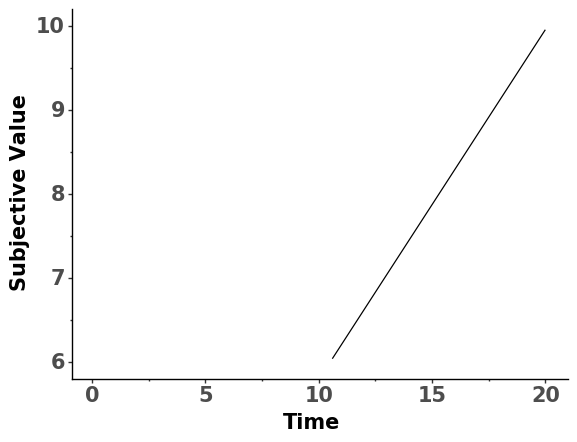

<ggplot: (8771303580809)>

In [264]:
# let me play with the exponential function 
# maybe latter I won't to wrap it up as a python class 

########### truncated exponetial function ########
time = bin * np.arange(1, delayMaxs[0] / bin + 1)
delayMax = delayMaxs[0]
# CDF = 1 - np.exp(-time)
CDF = 1 / len(time) * np.linspace(start=1, stop=len(time), num=len(time))
tokenValue = 10 
smallValue = 0
iti = 2
isPlot = False 

wtwObj, fig = wtw(time, CDF, tokenValue, smallValue, iti, delayMax, True)
gtMax_, Tstar_= calcSubjValue(wtwObj)

# plot the reward rate as a function of giving up time
fig['figRewardRate']

# plot the hazard function 
fig['figHazard'] + ylim((0, 0.1)) + ylab("Hazard rate") + myTheme

# plot the subjective value function 
ggplot(pd.DataFrame({'Time': wtwObj['time'], 'SubjValue': gtMax_}), aes("Time", "SubjValue")) + geom_line() +\
ylim((6, 10)) + myTheme + ylab("Subjective Value")

In [54]:
start = -1
stop = 0.001
step = 0.1
step * np.arange(start / step, stop / step)

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ])

In [51]:
nSim = 10
nTrial = 50

# for condition in conditions:
condition = "LP"

# initialize outputs for all simualtions
optimThreshold_ = np.zeros([nTrial, nSim])
optimRewardRate_ = np.zeros([nTrial, nSim])

# loop over simualtions
for smIdx in range(nSim):
    # initialize outputs for one simulation
    delays = np.array([])
    optimThresholds = np.zeros(nTrial)
    optimRewardRates = np.zeros(nTrial)

    # loop over trials
    for tIdx in range(nTrial):
        delays = np.append(delays, drawSample(condition))
        dist = sample2dist(delays, delayMaxs[0], step = 0.1)
        optimThresholds[tIdx], optimRewardRates[tIdx] = findOptim(dist)

    # save 
    optimThreshold_[:, smIdx] = optimThresholds
    optimRewardRate_[:, smIdx] = optimRewardRates


In [88]:
# I need to implement Joe's subjective value model here
subjectValues = {}
Tstars = {}

for cIdx in range(len(conditions)):
    condition = conditions[cIdx]
    delayMax = delayMaxs[cIdx]
    pdf = rewardDelayPDFs[condition]
    cdf = rewardDelayCDFs[condition]
    thisTime = time[condition]
    Rstar = optimRewardRates[condition] # opportunity cost
    ts = np.arange(0, delayMax + 0.1, 0.1)
    
    # initialize
    thisSubjectValues = np.zeros_like(ts)
    thisTstars = np.zeros_like(ts)
    
    # loop over different elapsed time values
    for i in range(len(ts)):
        t = ts[i]
        trctTime = thisTime[thisTime > t]
        # given the elapsed time value, t, loop over different waiting policies to find Tstar
        if t == delayMax:
            Tstar = t
            gt_max = tokenValue
        else:
            Tstar = t
            gt_max = -100
            for T in np.arange(t / 0.1, delayMax / 0.1 + 1) * 0.1:
                select = trctTime - 0.5 * bin < T
                trctPDF = pdf[thisTime > t] / sum(pdf[thisTime > t])
                at = tokenValue * sum(trctPDF[select]) # equality is not a good idea for python
                bt = sum((trctTime[trctTime <= T] - 0.5 * bin - t) * trctPDF[trctTime <= T]) + (T - t) * sum(trctPDF[trctTime > T]) 
                gt =   - bt * Rstar
                if gt > gt_max:
                    gt_max = gt
                    Tstar = T
        thisSubjectValues[i] = gt_max 
        thisTstars[i] = Tstar
    subjectValues[condition] = thisSubjectValues
    Tstars[condition] = thisTstars


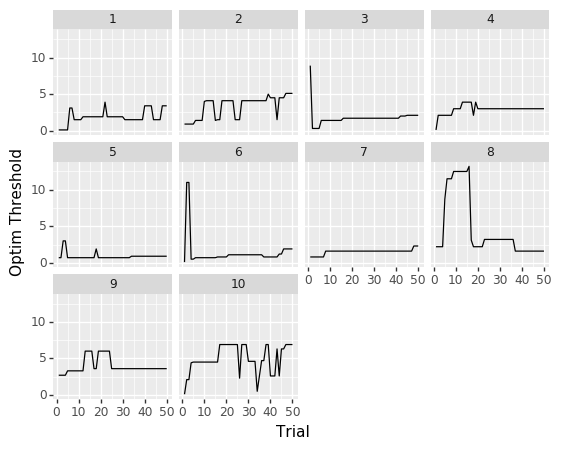

<ggplot: (305550993)>

In [111]:
plotData = pd.DataFrame({
        "threshold": np.reshape(optimThreshold_, -1, order = "F"),
    "trial": np.tile(np.arange(1, nTrial+1), nSim),
    "group": np.repeat(np.arange(1, nSim+1), nTrial)
}
)

ggplot(plotData, aes("trial", "threshold")) + geom_line() + facet_wrap(['group']) + \
xlab("Trial") + ylab("Optim Threshold")


# I think we can add a choice noise term to this model as well
# I should use Joe's model 

In [6]:
# plot block

# check the dist 
dist = sample2dist(delays, delayMaxs[0], 0.1)
plotData = pd.DataFrame.from_dict(dist)
ggplot(plotData, aes("time", "cdf")) + geom_point()

# calculate the trial-wise optimal policy
optimThresholds = np.zeros_like(delays)
optimRewardRates = np.zeros_like(delays)
for i in range(len(delays)):
    dist = sample2dist(delays[:(i+1)], delayMaxs[0], step = 0.1)
    optimThresholds[i], optimRewardRates[i] = findOptim(dist)

In [7]:
# example of the optimal model 
# initialize outputs for one simulation
nTrial = 50
delays = np.array([])
optimThresholds = np.zeros(nTrial)
optimRewardRates = np.zeros(nTrial)

# loop over trials
for tIdx in range(nTrial):
    delays = np.append(delays, drawSample(condition))
    dist = sample2dist(delays, delayMaxs[0], step = 0.1)
    optimThresholds[tIdx], optimRewardRates[tIdx] = findOptim(dist)

In [ ]:
# example of the optimal model 




In [143]:
# draw samples to predict the next delay
alpha = 0.1
beta = 0.01
tau = 10
eta = 5
stepSec = 0.2

# modeling parameters 
step = 1
delayMax = delayMaxs[1]

# 
# delays = np.append(np.repeat(0.5 , 50), delays)
nTrial = len(delays)

# initialize 
trialEarnings_ = np.repeat(0.0, nTrial)
timeWaited_ = np.repeat(0.0, nTrial)
sellTime_ = np.repeat(0.0, nTrial)
aveRewardRate_ = np.repeat(0.0, nTrial)
delays_ = []
elapsedTime = 0
pastDelays = np.array([])
# priorDelays = np.arange(0, 40) + 1
priorDelays = np.repeat(40, 40)
priorEarnings = np.repeat(tokenValue, len(priorDelays)) # assume the prior policy is to always wait. 
priorWeight = 1


# delays 
for i in range(nTrial):
    elapsedTime = elapsedTime + iti
    scheduledDelay = delays[i]

    # determine the empirical average reward rate 
    if(i == 0):
        aveRewardRateHat = np.sum(priorEarnings * priorWeight) / np.sum((priorDelays + iti)* priorWeight)
    else:
        possibleDelays = np.concatenate([priorDelays, pastDelays])
        possibleEarnings = np.concatenate([priorEarnings, trialEarnings_[:i]])
        weights = np.concatenate([np.repeat(priorWeight, len(priorDelays)), np.repeat(1, len(pastDelays))])
        aveRewardRateHat = np.sum(weights * possibleEarnings) / np.sum(weights * possibleDelays + iti)
    aveRewardRate_[i] =  aveRewardRateHat

    # make decisions on the fly
    timeWaited = 0 # reset timeWaited
    while(timeWaited <= delayMax):
        # for the following time interval [t, t + 1), predict the remaining delay 
        select = possibleDelays >= timeWaited 
        scheduledDelayHat = np.average(possibleDelays[select]) 
        remainDelayHat = scheduledDelayHat - timeWaited
        # action selection
        if(i == 0):
            pWait = 1
            decValue = np.nan
        else:
            decValue = remainDelayHat * aveRewardRateHat - tokenValue
            pWait = 1 / (1  + np.exp(decValue * tau - eta))
        
        if i == 0:
            decValue
            action = "wait"
        else:
            decValue = remainDelayHat * aveRewardRateHat - tokenValue # does this make sense to you ??? 
            action = "wait" if decValue <= 0 else "quit" # do I need an intercept here??
        # check the trial-wise output 
        # print([i, scheduledDelay, aveRewardRateHat, scheduledDelayHat, remainDelayHat, decValue, pWait, action, timeWaited]) # use this to check the performance of tau
        # check the status 
        tokenMature = (scheduledDelay >= timeWaited) & (scheduledDelay < (timeWaited + stepSec))  
        getToken = (action == 'wait' and tokenMature) 
        isTerminal = (getToken or action == "quit")
        if isTerminal:
            timeWaited_[i] = scheduledDelay if getToken else timeWaited 
            trialEarnings_[i] = tokenValue if getToken else smallReward
            sellTime_[i] = elapsedTime
            break
        # next time step
        timeWaited = timeWaited + stepSec
        elapsedTime = elapsedTime + stepSec
  # update pastDelays
    pastDelays = np.append(pastDelays, scheduledDelay)
        
# outputs 
thisTrialData = pd.DataFrame({
    "trialNum": np.arange(0, nTrial), 
    "condition": np.repeat(condition, nTrial),
    "trialEarnings": trialEarnings_, 
    "timeWaited": timeWaited_,
    "sellTime": sellTime_,
    "delay": delays,
    "aveRewardRate": aveRewardRate_,
})
      
    
    
wtwCeiling = min(delayMaxs)

# 
thisTrialData[thisTrialData['trialEarnings'] != smallReward]['timeWaited'] = \
thisTrialData[thisTrialData['trialEarnings'] != smallReward]['delay']

# initialize the trial-wise estimate of WTW
nTrial = thisTrialData.shape[0]
trialWTW = np.zeros(nTrial)


# loop over trial
lastQuitIdx = -1
for i in range(nTrial):
    if thisTrialData['trialEarnings'][i] == smallReward:
        currentWTW = thisTrialData['timeWaited'][i]
        lastQuitIdx = i
    else: 
        currentWTW = max(thisTrialData['timeWaited'][(lastQuitIdx + 1) : (i + 1)]) # count after the last quit index and include the current index
    trialWTW[i] = currentWTW


trialWTW


# so I think  I need to compare it to the optimal performance

# print([i, scheduledDelay, aveRewardRateHat, scheduledDelayHat, remainDelayHat, decValue, pWait, action, timeWaited])

array([1.30302595e+00, 4.00000000e+01, 4.00000000e+01, 4.00000000e+01,
       4.00000000e+01, 4.00000000e+01, 4.00000000e+01, 4.00000000e+01,
       4.00000000e+01, 4.00000000e+01, 1.60000000e+00, 4.82520949e+00,
       4.00000000e+01, 4.00000000e+01, 4.00000000e+01, 1.80000000e+00,
       1.91317125e+00, 2.40000000e+00, 1.68005676e+00, 2.20315084e+00,
       2.40000000e+00, 8.95838368e-02, 5.75015248e-01, 2.00000000e+00,
       1.45813862e-02, 2.40000000e+00, 2.40000000e+00, 5.74753930e-01,
       5.74753930e-01, 5.74753930e-01, 2.00000000e+00, 7.85107403e-02,
       2.00000000e+00, 3.44504894e-01, 3.44504894e-01, 7.07710703e-01,
       7.07710703e-01, 1.60000000e+00, 1.78340179e+00, 1.80000000e+00,
       4.84164123e-02, 1.55997270e+00, 1.80000000e+00, 1.80000000e+00,
       1.80000000e+00, 2.40000000e+00, 2.27945872e+00, 2.27945872e+00,
       2.40000000e+00, 1.66800614e+00])

In [144]:
thisTrialData['trialWTW'] = trialWTW
# investigate how the remaining delay function changes 
# for tIdx in range(nTrial):

bin = 0.1

tIdx = 30

# plot the cdf 
allDelays = np.concatenate([priorDelays, delays])
tempt = allDelays[:(40 + tIdx)]
dist = pd.DataFrame(sample2dist(tempt, delayMaxs[1], step = 0.1))
ggplot(dist, aes('time', "cdf")) + geom_point()



time = dist['time']
cdf = dist['cdf']

elapsedTimes = np.linspace(bin, delayMaxs[0] + bin, num = delayMaxs[1] / bin, endpoint = False)
remainingDelays = np.zeros_like(elapsedTimes)
for i in range(len(elapsedTimes)):
    elapsedTime = elapsedTimes[i]
    select = tempt > elapsedTime
    remainingDelays[i] = np.mean(tempt[select] - elapsedTime)
 

# should 
tokenValue - remainingDelays * thisTrialData['aveRewardRate'][tIdx]






array([ 1.37342788e+00,  1.25951382e+00,  1.14196400e+00,  1.15673318e+00,
        1.17150237e+00,  1.18627155e+00,  1.06544724e+00,  1.08021643e+00,
        1.09498561e+00,  1.10975480e+00,  8.42527325e-01,  8.57296510e-01,
        7.24695139e-01,  7.39464324e-01,  7.54233509e-01,  7.69002694e-01,
        6.32664519e-01,  6.47433704e-01,  6.62202889e-01,  6.76972074e-01,
        6.91741259e-01,  5.51411949e-01,  5.66181134e-01,  5.80950319e-01,
        5.95719504e-01,  4.51109254e-01,  4.65878439e-01,  3.16396219e-01,
        3.31165404e-01,  3.45934589e-01,  3.60703774e-01,  3.75472959e-01,
        2.21546552e-01,  2.36315737e-01,  7.68386292e-02,  9.16078142e-02,
        1.06376999e-01, -5.86671326e-02, -4.38979475e-02, -2.91287625e-02,
       -1.43595774e-02,  4.09607610e-04,  1.51787927e-02, -1.54938883e-01,
       -1.40169698e-01, -1.25400513e-01, -3.01483513e-01, -2.86714328e-01,
       -2.71945143e-01, -2.57175958e-01, -2.42406773e-01, -2.27637588e-01,
       -2.12868403e-01, -